In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms

In [2]:
# Image Transform 정의
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
# train(학습용) 데이터셋 로드
train_data = datasets.FashionMNIST(root='data', 
                                   train=True,        # 학습용 데이터셋 설정(True)
                                   download=True, 
                                   transform=transform                
                                  )

In [4]:
# test(학습용) 데이터셋 로드
test_data = datasets.FashionMNIST(root='data', 
                                  train=False,        # 검증용 데이터셋 설정(False)
                                  download=True, 
                                  transform=transform
                                 )

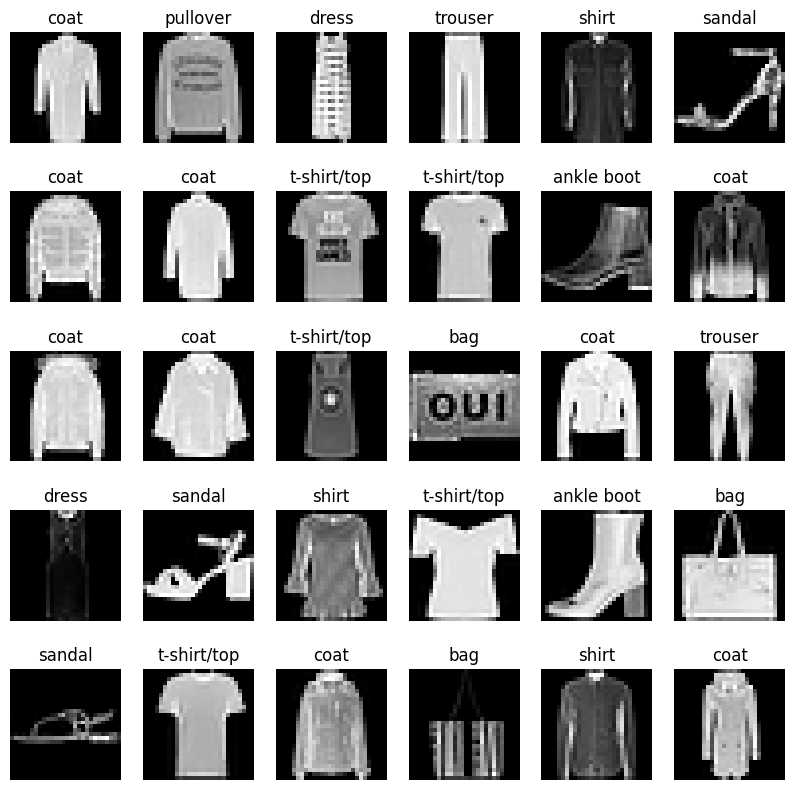

In [5]:
import matplotlib.pyplot as plt

labels_map = {
    0: "t-shirt/top",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}

figure = plt.figure(figsize=(10, 10))
cols, rows = 6, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
plt.show()

In [6]:
batch_size = 32 # batch_size 지정
num_workers = 8 # Thread 숫자 지정 (병렬 처리에 활용할 쓰레드 숫자 지정)

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           shuffle=True, 
                                           num_workers=num_workers)

In [8]:
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size,
                                          shuffle=False, 
                                          num_workers=num_workers)

In [9]:
# 1개의 배치 추출 후 Image, label의 shape 출력
img, lbl = next(iter(train_loader))
img.shape, lbl.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [10]:
# device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.output = nn.Linear(32, 10)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output(x)
        return x     

In [12]:
model = DNNModel() # Model 생성
model.to(device)   # device 에 로드 (cpu or cuda)

DNNModel(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)

In [13]:
# 옵티마이저를 정의합니다. 옵티마이저에는 model.parameters()를 지정해야 합니다.
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 손실함수(loss function)을 지정합니다. Multi-Class Classification 이기 때문에 CrossEntropy 손실을 지정하였습니다.
loss_fn = nn.CrossEntropyLoss()

In [14]:
from tqdm import tqdm  # Progress Bar 출력

In [15]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # 모델을 훈련모드로 설정합니다. training mode 일 때 Gradient 가 업데이트 됩니다. 반드시 train()으로 모드 변경을 해야 합니다.
    model.train()
    
    # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
    running_loss = 0
    corr = 0
    
    # 예쁘게 Progress Bar를 출력하면서 훈련 상태를 모니터링 하기 위하여 tqdm으로 래핑합니다.
    prograss_bar = tqdm(data_loader)
    
    # mini-batch 학습을 시작합니다.
    for img, lbl in prograss_bar:
        # image, label 데이터를 device에 올립니다.
        img, lbl = img.to(device), lbl.to(device)
        
        # 누적 Gradient를 초기화 합니다.
        optimizer.zero_grad()
        
        # Forward Propagation을 진행하여 결과를 얻습니다.
        output = model(img)
        
        # 손실함수에 output, label 값을 대입하여 손실을 계산합니다.
        loss = loss_fn(output, lbl)
        
        # 오차역전파(Back Propagation)을 진행하여 미분 값을 계산합니다.
        loss.backward()
        
        # 계산된 Gradient를 업데이트 합니다.
        optimizer.step()
        
        # output의 max(dim=1)은 max probability와 max index를 반환합니다.
        # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
        # 합계는 corr 변수에 누적합니다.
        corr += pred.eq(lbl).sum().item()
        
        # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
        # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
        # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
        running_loss += loss.item() * img.size(0)
        
    # 누적된 정답수를 전체 개수로 나누어 주면 정확도가 산출됩니다.
    acc = corr / len(data_loader.dataset)
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

In [16]:
def model_evaluate(model, data_loader, loss_fn, device):
    # model.eval()은 모델을 평가모드로 설정을 바꾸어 줍니다. 
    # dropout과 같은 layer의 역할 변경을 위하여 evaluation 진행시 꼭 필요한 절차 입니다.
    model.eval()
    
    # Gradient가 업데이트 되는 것을 방지 하기 위하여 반드시 필요합니다.
    with torch.no_grad():
        # loss와 accuracy 계산을 위한 임시 변수 입니다. 0으로 초기화합니다.
        corr = 0
        running_loss = 0
        
        # 배치별 evaluation을 진행합니다.
        for img, lbl in data_loader:
            # device에 데이터를 올립니다.
            img, lbl = img.to(device), lbl.to(device)
            
            # 모델에 Forward Propagation을 하여 결과를 도출합니다.
            output = model(img)
            
            # output의 max(dim=1)은 max probability와 max index를 반환합니다.
            # max probability는 무시하고, max index는 pred에 저장하여 label 값과 대조하여 정확도를 도출합니다.
            _, pred = output.max(dim=1)
            
            # pred.eq(lbl).sum() 은 정확히 맞춘 label의 합계를 계산합니다. item()은 tensor에서 값을 추출합니다.
            # 합계는 corr 변수에 누적합니다.
            corr += torch.sum(pred.eq(lbl)).item()
            
            # loss 값은 1개 배치의 평균 손실(loss) 입니다. img.size(0)은 배치사이즈(batch size) 입니다.
            # loss 와 img.size(0)를 곱하면 1개 배치의 전체 loss가 계산됩니다.
            # 이를 누적한 뒤 Epoch 종료시 전체 데이터셋의 개수로 나누어 평균 loss를 산출합니다.
            running_loss += loss_fn(output, lbl).item() * img.size(0)
        
        # validation 정확도를 계산합니다.
        # 누적한 정답숫자를 전체 데이터셋의 숫자로 나누어 최종 accuracy를 산출합니다.
        acc = corr / len(data_loader.dataset)
        
        # 결과를 반환합니다.
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [27]:
# 모델에 저장한 가중치를 로드합니다.
model.load_state_dict(torch.load('DNNModel.pth'))

<All keys matched successfully>

In [21]:
# 최대 Epoch을 지정합니다.
num_epochs = 20

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    # 훈련 손실과 정확도를 반환 받습니다.
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    # 검증 손실과 검증 정확도를 반환 받습니다.
    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)   

    # val_loss 가 개선되었다면 min_loss를 갱신하고 model의 가중치(weights)를 저장합니다.
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), 'DNNModel.pth')
    
    # Epoch 별 결과를 출력합니다.
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

100%|██████████| 1875/1875 [00:22<00:00, 82.44it/s]


[INFO] val_loss has been improved from inf to 0.59029. Saving Model!
epoch 01, loss: 0.07327, acc: 0.97245, val_loss: 0.59029, val_accuracy: 0.90230


100%|██████████| 1875/1875 [00:19<00:00, 96.41it/s] 


epoch 02, loss: 0.06508, acc: 0.97508, val_loss: 0.59112, val_accuracy: 0.89270


100%|██████████| 1875/1875 [00:19<00:00, 94.35it/s] 


epoch 03, loss: 0.06952, acc: 0.97357, val_loss: 0.59150, val_accuracy: 0.89840


100%|██████████| 1875/1875 [00:19<00:00, 95.07it/s] 


[INFO] val_loss has been improved from 0.59029 to 0.56118. Saving Model!
epoch 04, loss: 0.06394, acc: 0.97548, val_loss: 0.56118, val_accuracy: 0.89850


100%|██████████| 1875/1875 [00:19<00:00, 94.06it/s] 


epoch 05, loss: 0.06511, acc: 0.97468, val_loss: 0.59801, val_accuracy: 0.89830


100%|██████████| 1875/1875 [00:19<00:00, 94.85it/s] 


epoch 06, loss: 0.06231, acc: 0.97678, val_loss: 0.58880, val_accuracy: 0.89570


100%|██████████| 1875/1875 [00:19<00:00, 94.52it/s] 


epoch 07, loss: 0.06121, acc: 0.97662, val_loss: 0.62916, val_accuracy: 0.89590


100%|██████████| 1875/1875 [00:19<00:00, 95.15it/s] 


epoch 08, loss: 0.06023, acc: 0.97668, val_loss: 0.68720, val_accuracy: 0.89730


100%|██████████| 1875/1875 [00:19<00:00, 95.33it/s] 


epoch 09, loss: 0.05882, acc: 0.97768, val_loss: 0.63355, val_accuracy: 0.89700


100%|██████████| 1875/1875 [00:19<00:00, 96.13it/s] 


epoch 10, loss: 0.05585, acc: 0.97888, val_loss: 0.65785, val_accuracy: 0.89280


100%|██████████| 1875/1875 [00:19<00:00, 97.21it/s] 


epoch 11, loss: 0.05757, acc: 0.97798, val_loss: 0.67348, val_accuracy: 0.89440


100%|██████████| 1875/1875 [00:19<00:00, 95.88it/s] 


epoch 12, loss: 0.05746, acc: 0.97925, val_loss: 0.65037, val_accuracy: 0.89730


100%|██████████| 1875/1875 [00:18<00:00, 98.79it/s] 


epoch 13, loss: 0.05602, acc: 0.97895, val_loss: 0.67530, val_accuracy: 0.89530


100%|██████████| 1875/1875 [00:19<00:00, 95.58it/s] 


epoch 14, loss: 0.05309, acc: 0.98023, val_loss: 0.64716, val_accuracy: 0.89890


100%|██████████| 1875/1875 [00:19<00:00, 98.29it/s] 


epoch 15, loss: 0.05431, acc: 0.97982, val_loss: 0.64766, val_accuracy: 0.89960


100%|██████████| 1875/1875 [00:19<00:00, 94.00it/s] 


epoch 16, loss: 0.04926, acc: 0.98165, val_loss: 0.66728, val_accuracy: 0.89130


100%|██████████| 1875/1875 [00:19<00:00, 95.82it/s] 


epoch 17, loss: 0.05229, acc: 0.98007, val_loss: 0.69963, val_accuracy: 0.89620


100%|██████████| 1875/1875 [00:20<00:00, 93.72it/s] 


epoch 18, loss: 0.04704, acc: 0.98165, val_loss: 0.64989, val_accuracy: 0.89800


100%|██████████| 1875/1875 [00:20<00:00, 93.22it/s] 


epoch 19, loss: 0.05315, acc: 0.98060, val_loss: 0.69366, val_accuracy: 0.89710


100%|██████████| 1875/1875 [00:19<00:00, 96.00it/s] 


epoch 20, loss: 0.05131, acc: 0.98082, val_loss: 0.78799, val_accuracy: 0.89240


In [26]:
# 최종 검증 손실(validation loss)와 검증 정확도(validation accuracy)를 산출합니다.
final_loss, final_acc = model_evaluate(model, test_loader, loss_fn, device)
print(f'evaluation loss: {final_loss:.5f}, evaluation accuracy: {final_acc:.5f}')

evaluation loss: 0.78799, evaluation accuracy: 0.89240
